In [1]:
import numpy as np
import cv2
import sklearn
import scipy
import imageio
import math
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize_scalar, root_scalar
import glob

In [2]:
# read in images - note 7 images per col
image_paths = sorted(glob.glob("test_data_7/*"))
images = [
    cv2.imread(img) for img in image_paths
]


In [7]:
# calculate f: 2pi - 2 * sum(atan(d_i /f)) = 0
def compute_f(widths):
    widths = np.asarray(widths)
    def cost(f):
        goal = 2*np.pi
        val = 2*np.arctan(widths / f).sum()
        return val - goal

    def costprime(f):
        # derivative of cost
        return (widths / (widths ** 2 + f ** 2)).sum()
    
    res = root_scalar(cost, x0=300, fprime=costprime)
    return(res.root)

In [26]:
def combine_images(image1, image2, offset_x, offset_y):
    offset_x = -int(offset_x)
    offset_y = int(offset_y)
    if offset_x < 0:
        merge_width = max(image2.shape[1], image1.shape[1]-offset_x)
        warp_offset_x = 0
        ref_offset_x = offset_x
    else:
        merge_width = max(image2.shape[1] + offset_x, image1.shape[1])
        warp_offset_x = offset_x
        ref_offset_x = 0
    if offset_y < 0:
        merge_height = max(image2.shape[0], image1.shape[0]-offset_y)
        warp_offset_y = 0
        ref_offset_y = offset_y
    else:
        merge_height = max(image2.shape[0] + offset_y, image1.shape[0])
        warp_offset_y = offset_y
        ref_offset_y = 0
    
    combined_image = np.zeros((merge_height,merge_width,3)).astype(np.uint8)
    for y in range(image2.shape[0]):
        for x in range(image2.shape[1]):
            combined_image[y+warp_offset_y,x+warp_offset_x] = image2[y,x]
    
    for y in range(image1.shape[0]):
        for x in range(image1.shape[1]):
            if np.all((combined_image[y-ref_offset_y,x-ref_offset_x] == 0)):
                combined_image[y-ref_offset_y, x-ref_offset_x] = image1[y,x]
    return combined_image

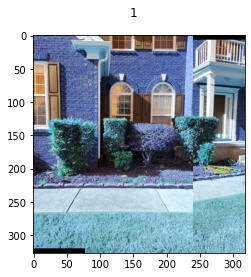

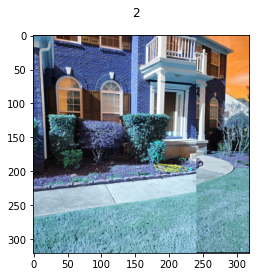

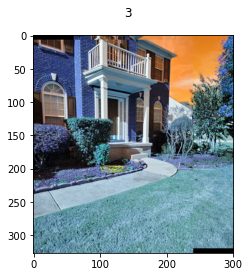

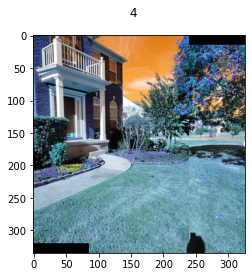

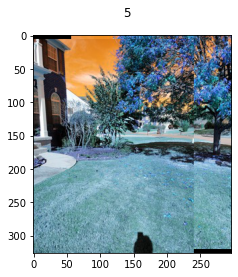

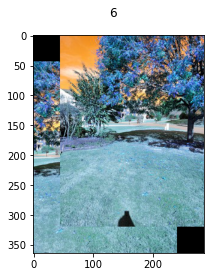

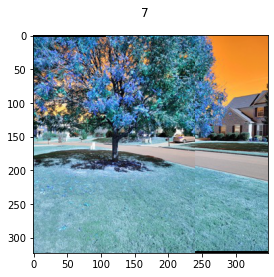

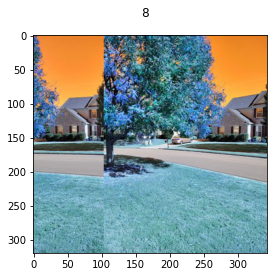

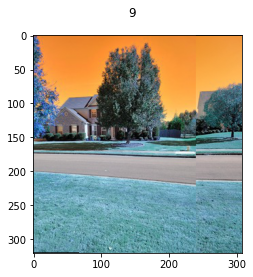

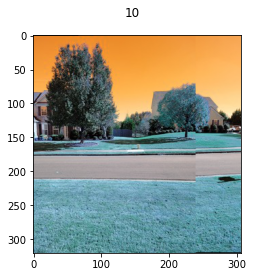

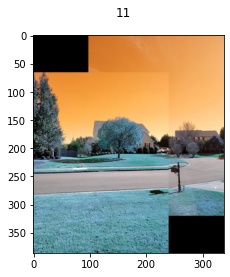

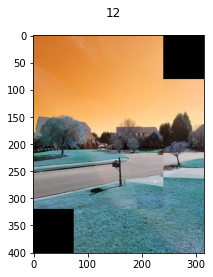

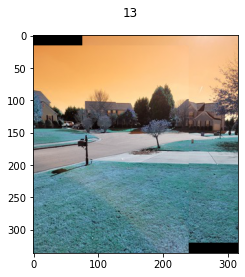

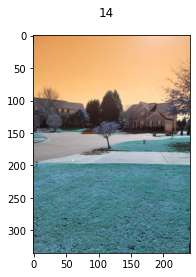

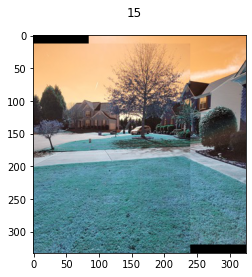

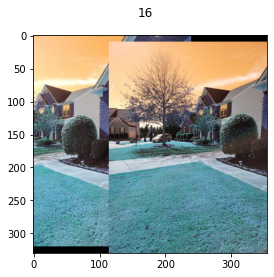

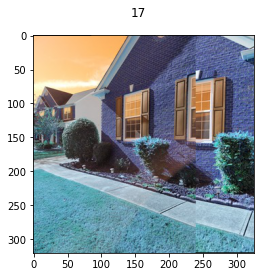

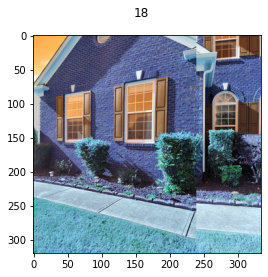

In [39]:
# calculate focal length from horizontal images - horizontal and vertical offsets
horizontal_images = images[::7] # 7 images per col
offsets = []
for i in range(1, len(horizontal_images)):
    offset = cv2.phaseCorrelate(
        rgb2gray(horizontal_images[i]), 
        rgb2gray(horizontal_images[i-1])
    )
    offsets.append(offset[0])
    # if offset[0][0] > 0:
    res = combine_images(horizontal_images[i], horizontal_images[i-1], offset[0][0], -offset[0][1])
    plt.suptitle(str(i))
    plt.imshow(res)
    plt.show()
offsets = np.array(offsets)
offsets_x = offsets[:, 0].ravel()

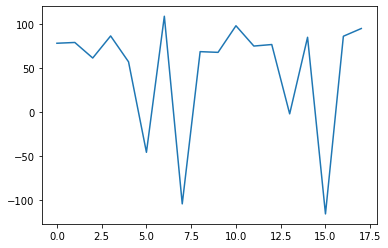

In [40]:
plt.plot(offsets_x)

In [43]:
# compute focal length
def cost(f):
    goal = 2*np.pi
    val = 2*np.arctan(offsets_x / f).sum()
    return goal - val

def costprime(f):
    # derivative of cost
    return (offsets_x / (offsets_x ** 2 + f ** 2)).sum()
res = root_scalar(cost, bracket=(0, 1000), fprime=costprime)
focal_length = res.root
print(focal_length)

265.89876668444356


In [45]:
# segment the columns
# I took the pictures in the order (horizontal, up 1, up 2, up 3, down 1, down 2, down 3)
# so the top-down order of the images is (3, 2, 1, 0, 4, 5, 6)
columns = []
for col_start in range(0, len(images), 7):
    col = []
    for i in (3,2, 1, 0, 4, 5,6):
        col.append(images[col_start + i])
    columns.append(col)

In [79]:
def compute_col_offsets(col):
    offsets = [(0, 0)]
    for i in range(1, len(col)):
        offset = cv2.phaseCorrelate(rgb2gray(col[i-1]), rgb2gray(col[i]))[0]
        offsets.append(offset)
    offsets = np.array(offsets)
    return offsets
offsets = compute_col_offsets(columns[0])
print(offsets)

def compute_col_angles(col, focal_length, horizontal_index = 0):
    # horizontal_index - index of horizontal image in column
    offsets = compute_col_offsets(col)
    angles = np.zeros((len(col), 2)) # x-direction, y-direction
    for i in range(1, len(col)):
        angles[i][0] = angles[i-1][0] + 2 * np.arctan(offsets[i][0] / (2 * focal_length))
        angles[i][1] = angles[i-1][0] + 2 * np.arctan(offsets[i][1] / (2 * focal_length))
    angles -= angles[horizontal_index]
    return angles
angles = compute_col_angles(columns[0], focal_length,horizontal_index=3)
print(angles * 180 / np.pi)

[[  0.           0.        ]
 [ -3.00139783 -68.47727524]
 [ -0.66730198 -60.57646249]
 [  2.24402579 -62.53472929]
 [ -1.10699307 -53.75767654]
 [ -3.53762169 -63.55543425]
 [ -1.16957568 -89.90015957]]
[[  0.61394401  28.04992198]
 [ -0.67948151  -0.83338008]
 [ -0.96706093   1.08858233]
 [  0.           0.        ]
 [ -0.47706625   4.5767313 ]
 [ -2.00154745   0.0735255 ]
 [ -2.50558377 -11.92627738]]


In [47]:
def compute_transformation_matrix(f, theta, phi): 
    r0 = [
        [1,  0,           0           ],
        [0,  np.cos(phi), -np.sin(phi)],
        [0,  np.sin(phi), np.cos(phi) ]
    ]
    r1 = [
        [np.cos(theta),  0, np.sin(theta)], 
        [      0,        1,      0       ], 
        [-np.sin(theta), 0, np.cos(theta)]
    ]
    r = np.matmul(np.asarray(r0), np.asarray(r1))
    v = [[f, 0, 0],[0,f,0],[0,0,1]]
    
    tran_mat = np.matmul(v, r) 
#     tran_mat = np.linalg.inv(tran_mat)
    return tran_mat

In [82]:
def haversine_dist(theta1, phi1,theta2, phi2):
    def haversine(th):
        return (1 - np.cos(th)) / 2
    h = haversine(phi2 - phi1) + np.cos(phi1) * np.cos(phi2) * haversine(theta2 - theta1)
    d = 2 * np.arcsin(np.sqrt(h))
    return d


def create_vertical_subimage(col, focal_length, horizontal_index = 0):
    angles = compute_col_angles(col,focal_length, horizontal_index) * np.asarray((1, -1))

    max_angle = np.absolute(angles[:, 1]).max()
    y_height = 2 * max_angle * focal_length + col[0].shape[1] + 100
    
    result = np.zeros((int(y_height), 480, 3), dtype=np.uint8)
    origin_y = result.shape[0] / 2
    origin_x = result.shape[1] / 2

    
    for y_coord in range(result.shape[0]):
        for x_coord in range(result.shape[1]):
            beta = (y_coord - origin_y) / focal_length
            alpha = (x_coord - origin_x) / focal_length
            
            # find the closest image
            best_idx, min_dist = None, float('inf')
            for i in range(len(col)):
                theta, phi = angles[i]
#                 dist = (theta - alpha) ** 2 + (phi - beta) ** 2
                # dist = haversine_dist(theta, phi, alpha, beta)
                dist = (phi - beta) ** 4
                if dist < min_dist:
                    best_idx = i
                    min_dist = dist
            projection = compute_transformation_matrix(focal_length, angles[best_idx][0], angles[best_idx][1])
#             p = np.array((y_coord - origin_y, x_coord - origin_x, 1)).reshape(-1, 1)
            # spherical to Cartesian
            p = np.array((np.cos(beta) * np.sin(alpha), np.sin(beta),np.cos(beta) * np.cos(alpha)))
            # p = np.array((alpha, beta, 1)).reshape(-1,1)
            q = projection @ p 
#             print(q)
            x, y, _ = q / q[-1]
#             print(x, y)
            if np.isnan(x) or np.isnan(y):
                continue
            x += col[best_idx].shape[1] / 2
            y += col[best_idx].shape[0] / 2
            x = int(x)
            y = int(y)
            if 0 <= x < col[best_idx].shape[1] and 0 <= y < col[best_idx].shape[0]:
                result[y_coord][x_coord] = col[best_idx][y][x]

    return result

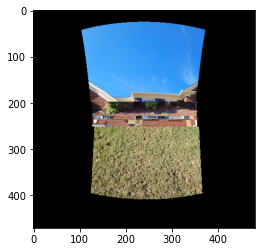

In [83]:
subim = create_vertical_subimage(columns[0], focal_length, horizontal_index=3)
plt.imshow(subim[..., ::-1])